This code generates the model SNe for each model type. 

Check up on Model 4, I think the mixed map has a normalization error. (map built in SNeCO/3.4cModelVisualization)

In [1]:
#import packages and initialize settings
import time
import os
import numpy as np
from astropy.io import fits, ascii
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
from reproject import reproject_interp
import aplpy
import scipy
from scipy.interpolate import interp1d

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

import sys
sys.path.append('./Python')
from nearest import findNearest
from deprojectGalaxy import deproject
from SNeGenerationModels import runModels
from getMapValue import getValue

In [2]:
#Get Galaxy names, distances, and fits file locations

# Unpack master table to get SNe information
GalaxyData = Table.read('../Data/0.MUSEData.csv', format='csv')
SampleData = Table.read('../Data/2.MUSESampleCat.csv', format='csv') 
SampleData.remove_column("Distance")
SampleData.remove_column("MUSENatMap")
SampleData.remove_column("MUSE150pcMap")
SampleData.remove_column("MUSEHII")
SampleData.remove_column("MUSERes")
SampleData.remove_column("IRACfiles")

database = join(GalaxyData, SampleData, keys = "Galaxy", join_type = 'inner')
centerCoords = [(database["GalRa"][i], database["GalDec"][i]) for i in range(len(database))]   

database[0:8]


Galaxy,Distance,GalRa,GalDec,PosAng,Incl,MUSENatRes,MUSEmapNat,MUSEmap150pc,MUSE_HII_reg,IRAC_files,Supernova,Type,Ra,Dec,InSample
str7,float64,float64,float64,float64,float64,float64,str71,str70,str50,str40,str11,str12,float64,float64,str4
NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,SN1995V,II,41.61152777777777,-0.4987861111111111,True
NGC1300,18.99,49.920815,-19.411114,278.0,31.8,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,SN2022acko,II,49.91245833333333,-19.39518888888889,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN2012fr,Ia,53.40057916666666,-36.12676944444445,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN2001du,II,53.3713125,-36.142111111111106,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN1983V,Ic,53.381876388888884,-36.14859166666667,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,True
NGC1433,18.63,55.506195,-47.221943,199.7,28.6,0.91,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1433-0.91asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1433-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1433_nebulae_mask_V2.fits,../Data/IRAC/ngc1433_irac1_atGauss4.fits,SN1985P,II,55.52640625,-47.209987222222225,True
NGC1566,17.69,65.00159,-54.93801,214.7,29.5,0.8,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1566-0.80asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1566-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1566_nebulae_mask_V2.fits,../Data/IRAC/ngc1566_irac1_atGauss4.fits,SN2021aefx,Ia,64.9725,-54.94808055555555,True


In [3]:
# Functions
def angDistToPc(x,galDist):
    return(galDist*10**6*np.tan(x*np.pi/180))

def nearestHII(galaxy, HII_file, centerCoord, pa, incl, galDist, SNra, SNdec):
    HII_val = []
    if os.path.isfile(HII_file):

        # read in fits files
        hdu_HII = pyfits.open(HII_file)
        HIIMap  = hdu_HII[0].data

        #Convert x & y pixels to ra and dec
        wcs      = WCS(hdu_HII[0].header, naxis=2)
        naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
        grid     = np.indices((naxis[1],naxis[0]))
        ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

        #deproject ra and dec to dx and dy
        radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec, return_offset=True)

        # Get the value from the HII map at the SN location
        pix_x, pix_y = wcs.wcs_world2pix(SNra, SNdec, 0, ra_dec_order=True)
        pix_x = [int(x) for x in pix_x]
        pix_y = [int(x) for x in pix_y]
        
        for i in range(len(SNra)):
            HII_val.append(HIIMap[pix_y[i], pix_x[i]])

        
        #flatten data structures 
        f_HII  = HIIMap.flatten()
        f_ra   = ra.flatten()
        f_dec  = dec.flatten()    
        f_dx   = dx.flatten()
        f_dy   = dy.flatten()

        #remove nans
#         keep  = np.where(np.isfinite(f_HII))
        keep  = np.where(f_HII >= 0)
        map_ra    = f_ra[keep]
        map_dec   = f_dec[keep]
        map_HII   = f_HII[keep]
        map_dx    = f_dx[keep]
        map_dy    = f_dy[keep]

        SN_Rad, SN_PA, SN_dx, SN_dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=SNra, dec=SNdec, return_offset=True) 
        
        nearestHII_ang, idx = findNearest(map_dx, SN_dx, map_dy, SN_dy)
        HIIra, HIIdec = map_ra[idx], map_dec[idx]
        nearestHII_pc = angDistToPc(nearestHII_ang,galDist)
        
        #Check if the SN is in an HII region and adjust nearest HII region value accordingly
        for i in range(len(SNra)):
            if HII_val[i] > 0:
                nearestHII_pc[i] = 0.
        
#         print("Nearest HII region [pc]", nearestHII_pc, galaxy)

    else:
        print("No file for ", galaxy)

        nearestHII_pc = float("nan")
        HIIra = float("nan")
        HIIdec = float("nan")
        
    return(nearestHII_pc, HIIra, HIIdec)


In [4]:
#group sample by galaxy
gal_groups = database.group_by('Galaxy')
galaxies = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

gs, imgs, HIIimgs,IRACimgs, names, types, ras, decs, dists, res = [],[],[],[],[],[],[],[],[],[]
galRa,galDec,galPA,galIncl = [],[],[],[]

for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    gs.append(gal_groups["Galaxy"][indices[i]])
    imgs.append(gal_groups["MUSEmapNat"][indices[i]])
    HIIimgs.append(gal_groups["MUSE_HII_reg"][indices[i]])
    IRACimgs.append(gal_groups["IRAC_files"][indices[i]])
    dists.append(gal_groups["Distance"][indices[i]])
    res.append(gal_groups["MUSENatRes"][indices[i]])
    galRa.append(gal_groups["GalRa"][indices[i]])
    galDec.append(gal_groups["GalDec"][indices[i]])
    galPA.append(gal_groups["PosAng"][indices[i]])
    galIncl.append(gal_groups["Incl"][indices[i]])
    
    #if gal_groups["SN_name"][indices[i]] != "SN1989B" and gal_groups["SN_name"][indices[i]] != "SN1973R":
    # Attach first SN per galaxy to a list
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    # attach additional  SN to list when galaxy has more than one
    while(indices[i] + j < indices[i+1]):    
        #if gal_groups["SN_name"][indices[i]+j] != "SN1989B" and gal_groups["SN_name"][indices[i]+j] != "SN1973R":
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    names.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)

print(gs)
print(ras)

['NGC1087', 'NGC1300', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']
[[41.61152777777777], [49.91245833333333], [53.40057916666666, 53.3713125, 53.381876388888884, 53.38349999999999], [55.52640625], [64.9725, 64.99512499999999, 65.0058875], [71.423975, 71.45607916666667], [170.04809375, 170.05796666666666, 170.07957933333336, 170.07072916666667, 170.0592513888889], [184.71836111111114, 184.71066666666667, 184.71690625, 184.70291666666668], [185.48760972222217, 185.47536458333335, 185.50184583333336, 185.4698125, 185.46016458333332, 185.48041875, 185.48991666666666], [185.72488194444443, 185.74543194444445, 185.6970833333333, 185.72892708333336, 185.73393055555553]]


In [5]:
    
# # run models 1-4 and store results
galCol, counter, int_mod1, int_mod2, int_mod3, near_mod1, near_mod2, near_mod3 = [],[],[],[],[],[],[],[]

for i in range(len(gs)):
# for i in range(0,1):
#     i = 8
    
    IRAC_hdu = pyfits.open(IRACimgs[i])
    IRAC_map = IRAC_hdu[0].data
    # Using MUSE map for coverage
    img_hdu = pyfits.open(imgs[i])
    img_map = img_hdu["HA6562_FLUX"].data
    

    wcs     = WCS(img_hdu["HA6562_FLUX"].header, naxis=2)
    naxis   = wcs._naxis # size of image naxis[0] = x and [1] = y
    grid    = np.indices((naxis[1],naxis[0]))
    ra, dec = wcs.wcs_pix2world(grid[1],grid[0],0)
    
    IRAC_repro, IRAC_foot = reproject_interp(IRAC_hdu, img_hdu["HA6562_FLUX"].header)

    f_img = img_map.flatten()
    f_IRAC = IRAC_repro.flatten() 
    f_ra  = ra.flatten()
    f_dec = dec.flatten()
    
#     keep = np.where(np.isfinite(f_img))
    keep = np.where(np.isfinite(f_img) & np.isfinite(f_IRAC))
    IRAC  = f_IRAC[keep]
    star_ra   = f_ra[keep]
    star_dec  = f_dec[keep]
    
    
    raArr1, decArr1, dxArr1, dyArr1, intArr1 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=1)
    raArr2, decArr2, dxArr2, dyArr2, intArr2 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=2)
    raArr3, decArr3, dxArr3, dyArr3, intArr3 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=3, starLight = IRAC, starRa = star_ra, starDec = star_dec)
    #raArr4, decArr4, dxArr4, dyArr4 = runModels(gals[i], mixedFiles[i], coords[i], posAngs[i], inclinations[i], dists[i], modelType=2)

    n_mod1_dist, n_mod1_ra, n_mod1_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr1, decArr1)
    n_mod2_dist, n_mod2_ra, n_mod2_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr2, decArr2)
    n_mod3_dist, n_mod3_ra, n_mod3_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr3, decArr3)
    #n55_mod4, n65_mod4 = nearestMCMethod(gals[i], images[i], errFiles[i], massFiles[i], coords[i], posAngs[i], inclinations[i], dists[i], raArr4, decArr4)

    
    if (type(n_mod1_dist) != float and type(n_mod1_dist) != np.float64):
        for j in range(len(n_mod1_dist)):
            galCol.append(gs[i])
            counter.append(j)
            near_mod1.append(n_mod1_dist[j])
            near_mod2.append(n_mod2_dist[j])
            near_mod3.append(n_mod3_dist[j])
            #n55mod4.append(n55_mod4[j])
    else:
        for j in range(100):
            galCol.append(gals[i])
            counter.append(j)
            near_mod1.append(np.float('nan'))
            near_mod2.append(np.float('nan'))
            near_mod3.append(np.float('nan'))
            #n55mod4.append(np.float('nan'))  
            
    intArr1    = np.nan_to_num(np.clip(intArr1,0,np.max(intArr1)))
    intArr2    = np.nan_to_num(np.clip(intArr2,0,np.max(intArr2)))
    intArr3    = np.nan_to_num(np.clip(intArr3,0,np.max(intArr3)))
    
    int_mod1.append(intArr1)
    int_mod2.append(intArr2)
    int_mod3.append(intArr3)
    
#     #plotting code here
#     fig = plt.figure(figsize=(8, 8), facecolor = 'white')

#     f1 = aplpy.FITSFigure(img_map, figure=fig, subplot=(1,3,1))
#     f1.tick_labels.hide()
#     f1.ticks.hide()
#     f1.axis_labels.hide()
#     f1.set_title("Random", fontsize = 16)

#     f2 = aplpy.FITSFigure(img_map, figure=fig,  subplot=(1,3,2))
#     f2.tick_labels.hide()
#     f2.ticks.hide()
#     f2.axis_labels.hide()
#     f2.set_title("Follow H-alpha Distribution", fontsize=16)


#     f3 = aplpy.FITSFigure(IRAC_repro, stretch="log", figure=fig,  subplot=(1,3,3))
#     f3.tick_labels.hide()
#     f3.ticks.hide()
#     f3.axis_labels.hide()
# #     f3.show_contour(massMap, ifr_hdu, levels = [10**5.5, 10**6.5], colors = ["grey", "black"])
#     f3.set_title("Follow Stellar Disk", fontsize=16)

    
# #     f4 = aplpy.FITSFigure(mixMap, mixhdu, figure=fig,  subplot=(2,2,4))
# #     f4.tick_labels.hide()
# #     f4.ticks.hide()
# #     f4.axis_labels.hide()
# # #     f4.show_contour(massMap, ifr_hdu, levels = [10**5.5, 10**6.5], colors = ["grey", "black"])
# #     f4.set_title("Hybrid", fontsize=16)

    
#     f1.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f1.set_nan_color('black')

#     f2.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f2.set_nan_color('black')

#     f3.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f3.set_nan_color('black')

# #     f4.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
# #     f4.set_nan_color('black')
    
#     fig.tight_layout()

#     xArr1, yArr1 = wcs.wcs_world2pix(raArr1,decArr1,0)
#     xArr2, yArr2 = wcs.wcs_world2pix(raArr2,decArr2,0)
#     xArr3, yArr3 = wcs.wcs_world2pix(raArr3,decArr3,0)
# #     xArr4, yArr4 = wcs.wcs_world2pix(raArr4,decArr4,0)

#     for k in range(len(dxArr3)):
#         f1.add_label(float(xArr1[k]), float(yArr1[k]), text='*', color='black', size = 22, weight="bold")
#         f2.add_label(float(xArr2[k]), float(yArr2[k]), text='*', color="black", weight="bold", size=22)
#         f3.add_label(float(xArr3[k]), float(yArr3[k]), text='*', color="black", weight="bold", size=22)
# #         f4.add_label(float(xArr4[k]), float(yArr4[k]), text='*', color="black", fontsize = 22, weight="bold")
#         f1.add_label(float(xArr1[k]), float(yArr1[k]), text='*', color='lime', size = 20)
#         f2.add_label(float(xArr2[k]), float(yArr2[k]), text='*', color="lime", size=20)
#         f3.add_label(float(xArr3[k]), float(yArr3[k]), text='*', color="lime", size=20)
# #         f4.add_label(float(xArr4[k]), float(yArr4[k]), text='*', color="lime", fontsize = 20)

#     figName = "../Figures/" + gs[i] + "Models.png"
#     fig.savefig(figName, dpi = 300)

    
int_mod1 = np.hstack(int_mod1)
int_mod2 = np.hstack(int_mod2)
int_mod3 = np.hstack(int_mod3)
    

# cdfSM_mod1 = np.sort(smMod1)/np.sum(smMod1)
# cdfSM_mod2 = np.sort(smMod2)/np.sum(smMod2) 
# cdfSM_mod3 = np.sort(smMod3)/np.sum(smMod3)
    
results = Table({"Galaxy": galCol,
                "ModelNum": counter,
                "near_Mod1_dist": near_mod1,
                "near_Mod2_dist": near_mod2,
                "near_Mod3_dist": near_mod3,
                "intMod1":int_mod1,
                "intMod2":int_mod2,
                "intMod3":int_mod3})

results.write("../Data/AllModels.csv", format = "csv", overwrite = True)

        
        
    

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [4.63912040e+

r_int: [1.96954661e+01 1.38092153e+01 7.05465815e+01 1.65489554e+02
 1.21380188e+02 3.32679387e+01 2.05336541e+01 4.31675639e+01
 2.83178691e+01 6.49273329e+02 3.33438262e+01 3.76378740e+01
 3.70070475e+03 4.16788140e+01 5.93632909e+01 2.74598825e+01
 3.84128833e+00 3.65496071e+01 2.73613408e+02 5.41618457e+02
 6.76743504e+01 2.14803366e+01 5.95686960e+01 3.67990329e+02
 2.71647069e+01 1.78063209e+01 5.44687673e+01 4.07471087e+01
 4.89549874e+01 9.80983983e+02 4.29950707e+02 5.13803059e+03
 6.62110313e+01 3.64698489e+01 4.46406663e+01 7.12983071e+01
 2.22570430e+01 3.88183764e+01 4.57351828e+02 3.21394189e+02
 5.62941901e+00 3.72450230e+02 2.89844957e+01 2.45004163e+03
 2.81070867e+01 1.43162612e+02 2.71827053e+02 4.00515346e+01
 3.06074582e+02 2.11090453e+02 1.51240612e+04 2.84543552e+01
 2.40046689e+01 3.12454876e+01 2.77246270e+02 1.27478643e+01
 2.52188571e+02 1.35756474e+02 2.10186378e+01 4.25777543e+01
 8.81961067e+01 2.62418518e+01 4.85422320e+01 1.14584965e+03
 2.11417817e+01 4

r_int: [2.37807596e+02 3.07296283e+03 1.77285008e+03 1.35653762e+03
 4.69553038e+02 1.05232115e+03 1.69451557e+03 8.29441504e+01
 2.02764755e+02 2.65225538e+03 8.06845406e+03 9.19820766e+03
 3.06438053e+03 7.00831330e+01 1.18120166e+03 6.48985935e+04
 1.97259726e+01 3.35251819e+02 1.65229754e+01 2.19295386e+02
 8.76411579e+02 3.04692756e+02 1.29646108e+03 3.21652665e+03
 1.73444175e+04 1.38431367e+04 1.44927666e+03 1.11203961e+03
 3.17012333e+02 1.70656212e+03 1.48197189e+03 2.63383272e+03
 6.83316955e+03 2.92208316e+01 2.59464164e+03 2.68941601e+01
 7.27179739e+01 2.67387597e+03 5.94926332e+02 3.07043419e+02
 1.15636078e+03 5.58374311e+03 1.22785449e+03 2.10535640e+01
 2.63439748e+02 4.05351733e+01 3.37846730e+03 1.23314495e+03
 9.53404249e+01 4.46728341e+02 7.14729959e+03 3.56940424e+02
 7.57330887e+01 1.07092461e+03 2.86801350e+03 4.70602456e+02
 2.71622961e+01 1.67707834e+02 1.42342618e+01 7.70066664e+02
 1.88363206e+03 1.78261733e+03 2.24442326e+01 1.21051525e+02
 4.80576074e+02 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [1.10322375e+

r_int: [ 2074.81263313    97.50004289   954.13858675  2671.66699273
   203.94315681  3700.15043575   608.89598497  3628.87062745
  2302.75377216  2824.36774561  5036.90163919   248.22429386
   212.66585553   477.22313172 29805.83757263   185.26074487
   634.54644064  4448.04296444  1770.89707263   246.3101852
   278.07279129   662.63382651  1246.32557953   967.91598195
  2212.84223717  3832.89541867   191.67541763   222.1903442
   185.52196546   923.91587676   268.87969176   207.27571224
  2585.3121489    245.30116573   142.08261956  1031.17010253
   210.95690546   344.03978211   269.11408867   480.3282969
   193.46879936  1600.91103502  1258.8557565    173.96047915
    85.26903249   392.51750631   802.73772594   760.10117532
   222.18129733  1235.94896067   396.14476002   301.76400612
  5881.85064967   450.3689329    163.83227338   210.64074863
   372.421299     778.6456079    703.72522533   251.85485397
   266.70600221   163.05838588  2237.49182047   251.72987132
  2922.82873152    8

r_int: [  6879.17894072  22321.14833568    298.77794219  43037.43120058
  34636.94706368    769.18281221  79754.30063724   1317.90149204
  35560.61770512   5088.58876198  20107.41454893   1519.88911505
   2653.48943083  24971.48949578 111393.52724966   7981.27279698
    742.73875912 105214.24364021   3565.39051835   8392.34628748
   9317.82632436   2068.57624756  10637.01968637  27172.93711333
   3684.72194098  13294.57736055   2461.27892959   7435.52558296
   2475.97936954    507.48933689   1632.37715939   3304.34017537
   3174.50835986   5917.06936387  23257.26460847   4692.57929734
  67228.02456494  14083.15836324    847.63087948   7082.46419172
   5364.92527295   8545.91778116  20630.8705103   26877.19618605
   2303.22981576   6066.06077927  32654.8382212    2560.03254045
   6525.05070602   1311.69427657  18653.89121968   2426.07941095
   1657.02194418   9143.14295179   9796.16591424  10085.78043418
    694.74998459  13910.81801536   1194.24051955   4227.52287223
   4283.48912916  

In [6]:
# print(len(galCol))
# print(len(counter))
# print(len(near_mod1))
# print(len(near_mod2))
# print(len(near_mod3))
# np.hstack(int_mod1)
# print(len(smMod2))
# print(len(cdfSM_mod3))

In [7]:
import math
# get the real SN sample's distances (copied over from 1c)
realSNe = [0,130,524,88,0,201,0,120,100,0,0,5,0,0,29,0,0,11,0,7,0,0,44,0,36,22,14,214,63,8,13,0,0]

# Here make CDFs of the distances from the generated SNe to the nearest HII regions
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

nm1 = [x for x in modelResults["near_Mod1_dist"] if math.isnan(x) == False]
nm2 = [x for x in modelResults["near_Mod2_dist"] if math.isnan(x) == False]
nm3 = [x for x in modelResults["near_Mod3_dist"] if math.isnan(x) == False]

# nm4 = np.concatenate((nm2[0:1914],nm3[1914:]))


In [19]:
# print(nm2)

In [9]:
def findNear(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def makeCDFs(array):
    count, bins_count = np.histogram(array, bins=100)
    xVals = bins_count[1:]
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return(xVals, cdf)

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)


In [24]:
#original idea for how this should work
def randomPull(modelArr, numSNe=33, numRuns=1000):
    # pull intensity vals at locations of 33 model SNe 1000 times.    
    allPulls = []
    # iterate over 1000 runs
    for i in range(numRuns):
        singlePulls = []
        # iterate over number of SNe
        for j in range(numSNe):
            # choose a random distance from model SNe
            val = np.random.choice(modelArr)
            singlePulls.append(val)
        # sort the model SNe distances and save
        sorted_pulls = np.sort(singlePulls)
        sortedPulls_y = np.sort(singlePulls)
        sortedPulls_x = np.linspace(0,len(sortedPulls_y),len(sortedPulls_y))
        y_f = interp1d(sortedPulls_x,sortedPulls_y,'linear')
        x = np.linspace(0,len(sortedPulls_y),1000)


#         sortedPulls_x = np.sort(singlePulls)
#         sortedPulls_y = np.linspace(0,len(sortedPulls_x),len(sortedPulls_x))        
#         y_f = interp1d(sortedPulls_x,sortedPulls_y,'cubic')
#         x = np.linspace(0,len(sortedPulls_y),1000)   
    
        y = y_f(x)
        
        
        allPulls.append(y)
#         allPulls.append(sorted_pulls)
        
        
        
    # Interpolate after each draw
        
        
        
    # Find 1000 closest random pull values to each dist value in model SN array       
    allPer16Vals, allPer50Vals, allPer84Vals = [],[],[]
    for i in range(len(modelArr)):
        SNlocVals=[]
        for j in range(numRuns):
#             find the actual distance value that is the closest to the generated model values 
            SNlocVals.append(findNear(allPulls[j], modelArr[i]))
            
            
            
            
            
    # now find 16-84th percentiles from each of these local distributions around x value    
        locVals = np.sort(SNlocVals)
#         locVals = np.sort(allPulls[i])
        per16Vals = np.percentile(locVals,16)
        allPer16Vals.append(per16Vals)
        per50Vals = np.percentile(locVals,50)     
        allPer50Vals.append(per50Vals)
        per84Vals = np.percentile(locVals,84)
        allPer84Vals.append(per84Vals)

    return(allPer16Vals, allPer50Vals, allPer84Vals)

In [25]:
nSMm1_16, nSMm1_50, nSMm1_84 = randomPull(nm1)
nSMm2_16, nSMm2_50, nSMm2_84 = randomPull(nm2)
nSMm3_16, nSMm3_50, nSMm3_84 = randomPull(nm3)
# nSMm4_16, nSMm4_50, nSMm4_84 = randomPull(nm4)


# want to recreate ecdf plot with pyplot    
SNe,  ySNe  = ecdf(realSNe)
mod1, ymod1 = makeCDFs(nm1)
mod2, ymod2 = makeCDFs(nm2)
mod3, ymod3 = makeCDFs(nm3)
# mod4, ymod4 = makeCDFs(nSMm4)

mod1_16, ymod1_16 = makeCDFs(nSMm1_16)
mod1_50, ymod1_50 = makeCDFs(nSMm1_50)
mod1_84, ymod1_84 = makeCDFs(nSMm1_84)
mod2_16, ymod2_16 = makeCDFs(nSMm2_16)
mod2_50, ymod2_50 = makeCDFs(nSMm2_50)
mod2_84, ymod2_84 = makeCDFs(nSMm2_84)
mod3_16, ymod3_16 = makeCDFs(nSMm3_16)
mod3_50, ymod3_50 = makeCDFs(nSMm3_50)
mod3_84, ymod3_84 = makeCDFs(nSMm3_84)
# mod4_16, ymod4_16 = makeCDFs(nSMm4_16)
# mod4_50, ymod4_50 = makeCDFs(nSMm4_50)
# mod4_84, ymod4_84 = makeCDFs(nSMm4_84)

# mod2_50b, ymod2_84b = [],[]
# for i in range(len(mod2_50)):
#     mod2_50b.append((mod2_16[i] + mod2_84[i]) / 2.)
#     ymod2_84b.append(ymod2_84[i] +0.01)


In [26]:
# new50, yn16, yn84 = [],[],[]

# for i in range(len(mod2_50)):
#     yn16.append(np.min([ymod2_16[i], ymod2_50[i], ymod2_84[i]])
#     yn84.append(np.max[ymod2_16[i], ymod2_50[i], ymod2_84[i]])               
#     new50.append(np.median([mod2_16[i], mod2_50[i], mod2_84[i]]))
    

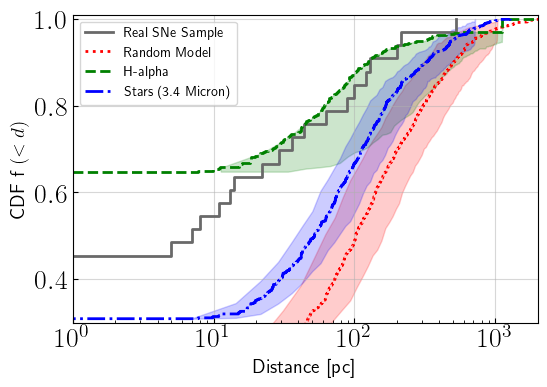

In [32]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,4))

# ax.plot(mod2, ymod2, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
sns.ecdfplot(realSNe, color = "dimgrey",  label="Real SNe Sample", ax=ax,lw=2)
sns.ecdfplot(nm1, label="Random Model", color='red', ls=":",ax=ax,lw=2)
sns.ecdfplot(nm2, label="H-alpha", color='green', ls="--",lw=2,ax=ax)
sns.ecdfplot(nm3, label="Stars (3.4 Micron)", color='blue', ls="-.",lw=2,ax=ax)
# ax[0].plot(mod4, ymod4, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
# ax.plot(mod2, ymod2, label="H-alpha", color='green', ls="--",lw=2)
ax.fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
ax.fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
# ax.fill_between(x=mod2_50, y1=ymod2_50,y2=ymod2_84, color='green', alpha=0.2)
ax.fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# ax[0].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
ax.set_xscale('log')
ax.set_ylim (0.3,1.01)
ax.set_xlim(1,2000)
ax.legend(loc='best')

# sns.ecdfplot(nSMIa,color = "black", ls=':', label="Real SNe Ia", ax=ax[1],lw=2)
# sns.ecdfplot(nSMII,color = "black", ls='-',  label="Real SNe II", ax=ax[1],lw=2)
# sns.ecdfplot(nSMIbc,color = "black", ls='--',  label="Real SNe Ibc", ax=ax[1],lw=2)
# sns.ecdfplot(nSMunc,color = "black", ls='-.',  label="Real Unclassified", ax=ax[1],lw=2)

# ax[1].plot(mod1, ymod1, color='red', ls=":",lw=2)
# ax[1].plot(mod2, ymod2, color='green', ls="--",lw=2)
# ax[1].plot(mod3, ymod3, color='blue', ls="-.",lw=2)
# # ax[1].plot(mod4, ymod4, color='purple', ls="-",lw=2)
# ax[1].fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
# ax[1].fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
# ax[1].fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# # ax[1].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
# ax[1].set_xscale('log')
# ax[1].set_ylim (0.3,1.01)
# ax[1].set_xlim(60,5000)

# ax[1].legend(loc='best')

ax.tick_params(axis = "both", which = "both", direction = "in")
# ax[1].tick_params(axis = "both", which = "both", direction = "in")

plt.xlabel("Distance [pc]", fontsize = 14)
ax.set_ylabel(r"CDF f $(< d)$", fontsize = 14)
# ax[1].set_ylabel("CDF f (< d)", fontsize = 14)
ax.grid(which='major', alpha=0.5)
# ax[1].grid(which='major', alpha=0.5)
fig.savefig("../Figures/DistanceCDF.png", dpi=300)
plt.show()
plt.close()